In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.6


# Interpolation with PyMC3

## A 1D example

To start, we'll do a simple 1D example where we have a model evaluated at control points and we interpolate between them to estimate the model value.

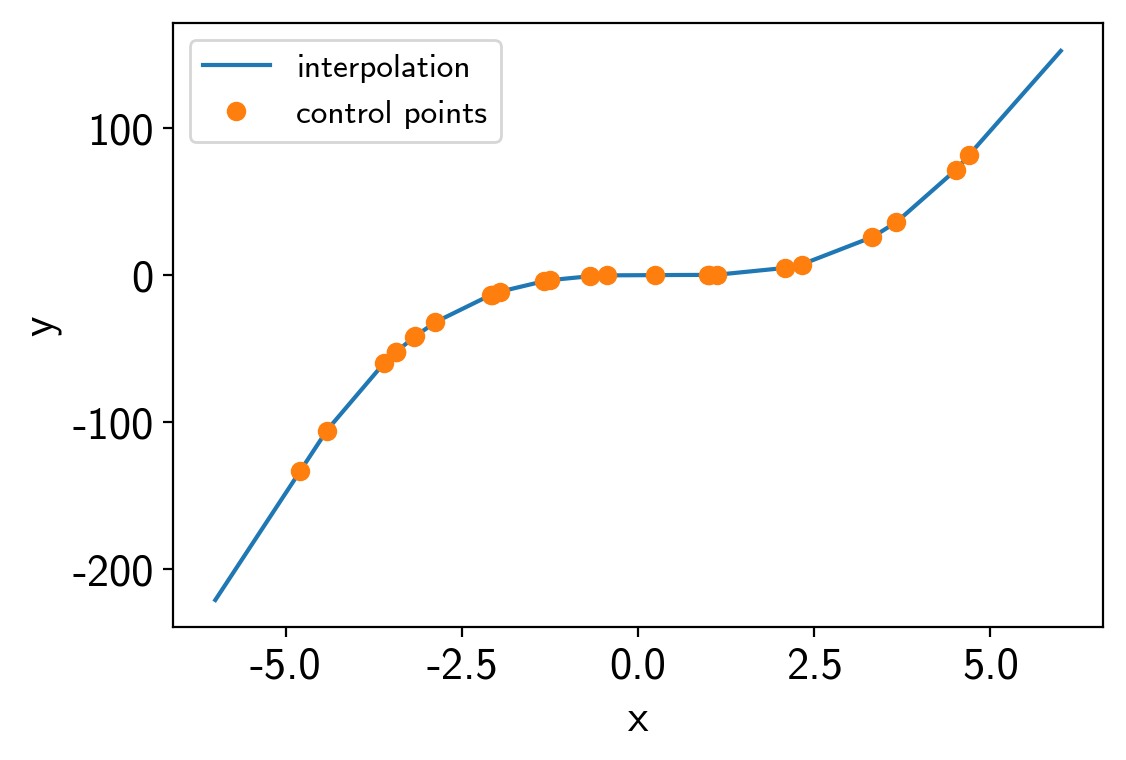

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

np.random.seed(42)
x = np.sort(np.random.uniform(-5, 5, 25))
points = [x]
values = x**3-x**2

interpolator = xo.interp.RegularGridInterpolator(points, values[:, None])

t = np.linspace(-6, 6, 5000)
plt.plot(t, interpolator.evaluate(t[:, None]).eval(), label="interpolation")
plt.plot(x, values, "o", label="control points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=12);

Here's how we build the PyMC3 model:

In [4]:
import pymc3 as pm

truth = 45.0
data_sd = 8.0
data_mu = truth + data_sd * np.random.randn()

with pm.Model() as model:
    
    # The value passed into the interpolator must have the shape
    # (ntest, ndim), but in our case that is (1, 1)
    xval = pm.Uniform("x", lower=-8, upper=8, shape=(1, 1))
    
    # Evaluate the interpolated model and extract the scalar value
    # we want
    mod = pm.Deterministic("y", interpolator.evaluate(xval)[0, 0])
    
    # The usual likelihood
    pm.Normal("obs", mu=mod, sd=data_sd, observed=data_mu)
    
    # Sampling!
    trace = pm.sample(draws=1000, tune=2000, step_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [x]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 618/12000 [00:00<00:01, 6176.10draws/s]

Sampling 4 chains:  11%|█         | 1302/12000 [00:00<00:01, 6360.66draws/s]

Sampling 4 chains:  16%|█▋        | 1959/12000 [00:00<00:01, 6418.78draws/s]

Sampling 4 chains:  23%|██▎       | 2805/12000 [00:00<00:01, 6918.74draws/s]

Sampling 4 chains:  30%|██▉       | 3551/12000 [00:00<00:01, 7072.02draws/s]

Sampling 4 chains:  36%|███▌      | 4339/12000 [00:00<00:01, 7292.52draws/s]

Sampling 4 chains:  44%|████▎     | 5246/12000 [00:00<00:00, 7746.74draws/s]

Sampling 4 chains:  50%|█████     | 6000/12000 [00:00<00:00, 7682.65draws/s]

Sampling 4 chains:  56%|█████▌    | 6743/12000 [00:00<00:00, 7543.85draws/s]

Sampling 4 chains:  64%|██████▍   | 7699/12000 [00:01<00:00, 8052.70draws/s]

Sampling 4 chains:  71%|███████   | 8502/12000 [00:01<00:00, 7018.18draws/s]

Sampling 4 chains:  79%|███████▉  | 9508/12000 [00:01<00:00, 7717.26draws/s]

Sampling 4 chains:  86%|████████▌ | 10317/12000 [00:01<00:00, 7473.05draws/s]

Sampling 4 chains:  92%|█████████▏| 11092/12000 [00:01<00:00, 6604.26draws/s]

Sampling 4 chains:  98%|█████████▊| 11791/12000 [00:01<00:00, 4584.30draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [00:01<00:00, 6383.71draws/s]

And here are the results:

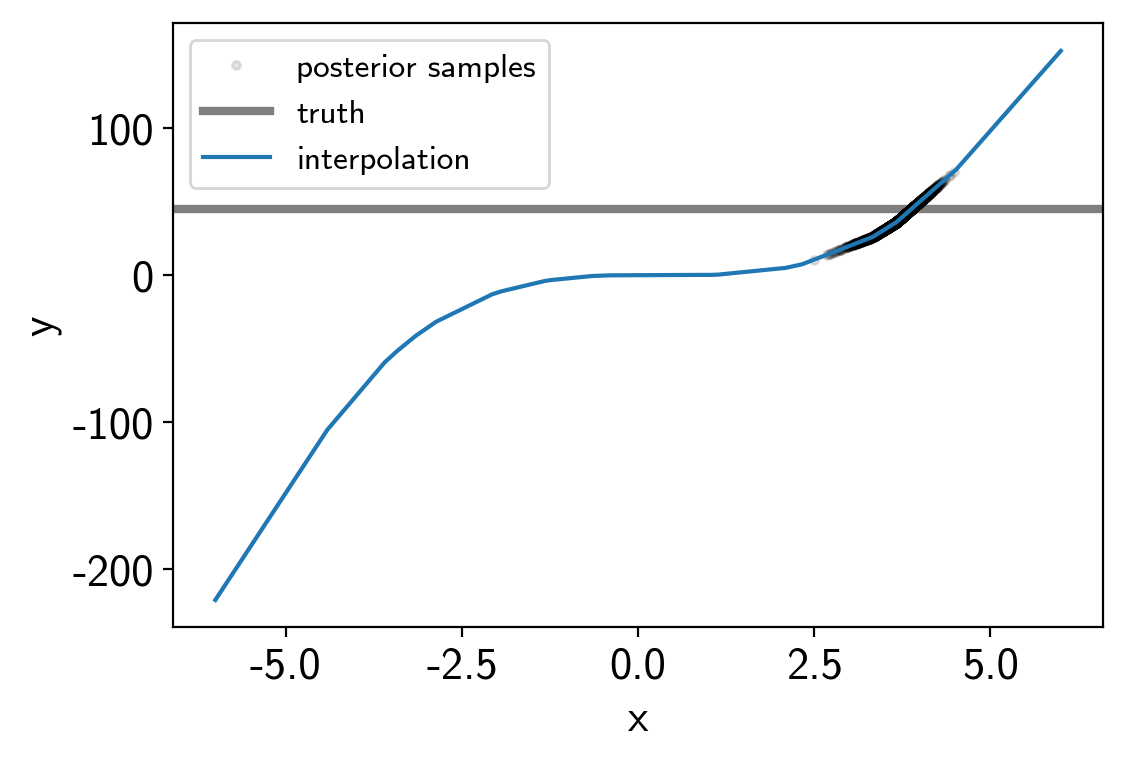

In [5]:
t = np.linspace(-6, 6, 5000)
plt.plot(trace["x"][:, 0, 0], trace["y"], ".k", alpha=0.1, label="posterior samples")
plt.axhline(truth, color="k", lw=3, alpha=0.5, label="truth")
plt.plot(t, interpolator.evaluate(t[:, None]).eval(), label="interpolation")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=12);

## A 2D example

In this case, we'll interpolate a 2D function. This one is a hard one because the posterior is a ring, but it demonstrates the principle.

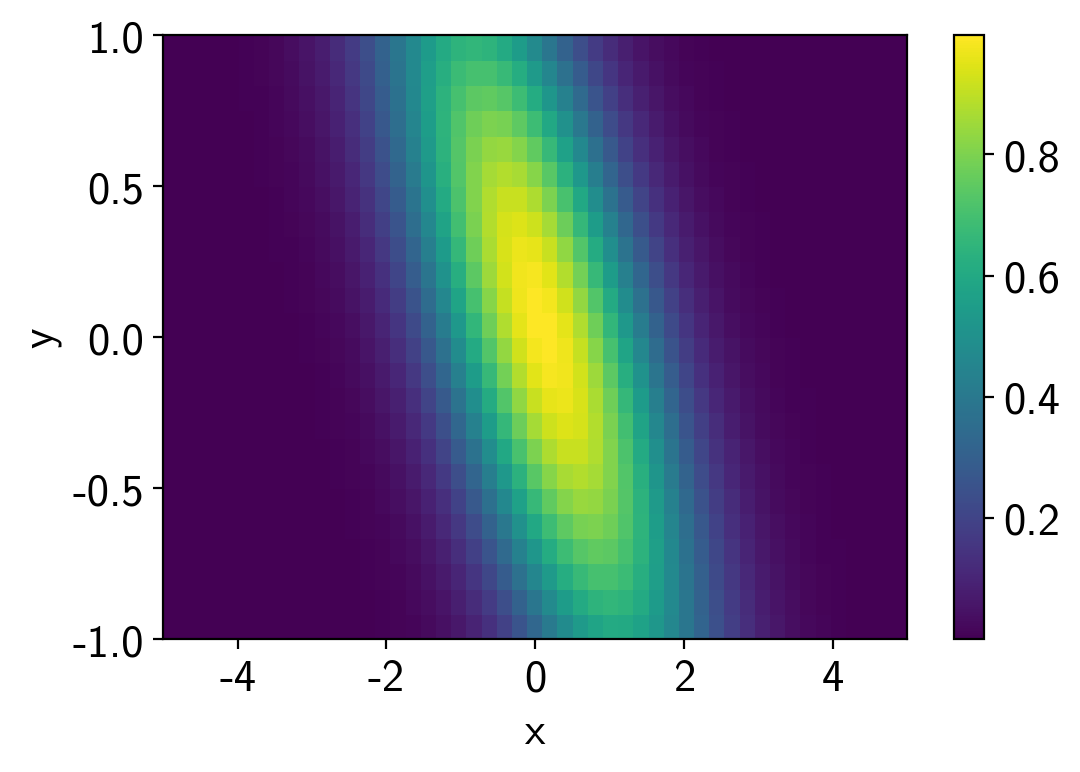

In [6]:
points = [
    np.linspace(-5, 5, 50),
    np.linspace(-1, 1, 25),
]
values = np.exp(-0.5*(points[0]**2)[:, None] - 0.5*(points[1]**2 / 0.5)[None, :] - points[0][:, None]*points[1][None, :])

interpolator = xo.interp.RegularGridInterpolator(points, values[:, :, None], nout=1)

plt.pcolor(points[0], points[1], values.T)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y");

Set things up and sample.

In [7]:
import theano.tensor as tt

data_mu = 0.6
data_sd = 0.1

with pm.Model() as model:
    
    xval = pm.Uniform("x", lower=-5, upper=5, shape=(1,))
    yval = pm.Uniform("y", lower=-1, upper=1, shape=(1,))
    xtest = tt.stack([xval, yval], axis=-1)
    
    mod = interpolator.evaluate(xtest)
    
    # The usual likelihood
    pm.Normal("obs", mu=mod, sd=data_sd, observed=data_mu)
    
    # Sampling!
    trace = pm.sample(draws=4000, tune=4000, step_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [y, x]


Sampling 4 chains:   0%|          | 0/32000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 118/32000 [00:00<00:27, 1176.75draws/s]

Sampling 4 chains:   1%|          | 339/32000 [00:00<00:23, 1368.67draws/s]

Sampling 4 chains:   2%|▏         | 637/32000 [00:00<00:19, 1633.19draws/s]

Sampling 4 chains:   3%|▎         | 934/32000 [00:00<00:16, 1886.23draws/s]

Sampling 4 chains:   4%|▍         | 1270/32000 [00:00<00:14, 2170.27draws/s]

Sampling 4 chains:   5%|▍         | 1574/32000 [00:00<00:12, 2371.02draws/s]

Sampling 4 chains:   6%|▌         | 1906/32000 [00:00<00:11, 2590.16draws/s]

Sampling 4 chains:   7%|▋         | 2230/32000 [00:00<00:10, 2755.52draws/s]

Sampling 4 chains:   8%|▊         | 2564/32000 [00:00<00:10, 2907.24draws/s]

Sampling 4 chains:   9%|▉         | 2883/32000 [00:01<00:09, 2986.65draws/s]

Sampling 4 chains:  10%|▉         | 3192/32000 [00:01<00:09, 2905.99draws/s]

Sampling 4 chains:  11%|█         | 3507/32000 [00:01<00:09, 2972.63draws/s]

Sampling 4 chains:  12%|█▏        | 3811/32000 [00:01<00:09, 2985.04draws/s]

Sampling 4 chains:  13%|█▎        | 4150/32000 [00:01<00:08, 3094.61draws/s]

Sampling 4 chains:  14%|█▍        | 4464/32000 [00:01<00:08, 3074.36draws/s]

Sampling 4 chains:  15%|█▍        | 4775/32000 [00:01<00:09, 2965.00draws/s]

Sampling 4 chains:  16%|█▌        | 5093/32000 [00:01<00:08, 3024.87draws/s]

Sampling 4 chains:  17%|█▋        | 5437/32000 [00:01<00:08, 3135.40draws/s]

Sampling 4 chains:  18%|█▊        | 5754/32000 [00:01<00:08, 3013.86draws/s]

Sampling 4 chains:  19%|█▉        | 6059/32000 [00:02<00:08, 2951.03draws/s]

Sampling 4 chains:  20%|██        | 6402/32000 [00:02<00:08, 3077.32draws/s]

Sampling 4 chains:  21%|██        | 6717/32000 [00:02<00:08, 3094.42draws/s]

Sampling 4 chains:  22%|██▏       | 7083/32000 [00:02<00:07, 3243.86draws/s]

Sampling 4 chains:  23%|██▎       | 7415/32000 [00:02<00:07, 3263.92draws/s]

Sampling 4 chains:  24%|██▍       | 7744/32000 [00:02<00:07, 3110.06draws/s]

Sampling 4 chains:  25%|██▌       | 8072/32000 [00:02<00:07, 3158.55draws/s]

Sampling 4 chains:  26%|██▌       | 8397/32000 [00:02<00:07, 3178.99draws/s]

Sampling 4 chains:  27%|██▋       | 8717/32000 [00:02<00:07, 3161.76draws/s]

Sampling 4 chains:  28%|██▊       | 9035/32000 [00:02<00:07, 3114.84draws/s]

Sampling 4 chains:  29%|██▉       | 9348/32000 [00:03<00:07, 3082.30draws/s]

Sampling 4 chains:  30%|███       | 9698/32000 [00:03<00:06, 3194.77draws/s]

Sampling 4 chains:  31%|███▏      | 10020/32000 [00:03<00:07, 3087.87draws/s]

Sampling 4 chains:  32%|███▏      | 10331/32000 [00:03<00:07, 3047.49draws/s]

Sampling 4 chains:  33%|███▎      | 10638/32000 [00:03<00:07, 3045.72draws/s]

Sampling 4 chains:  34%|███▍      | 10999/32000 [00:03<00:06, 3194.05draws/s]

Sampling 4 chains:  35%|███▌      | 11334/32000 [00:03<00:06, 3237.84draws/s]

Sampling 4 chains:  37%|███▋      | 11684/32000 [00:03<00:06, 3305.93draws/s]

Sampling 4 chains:  38%|███▊      | 12017/32000 [00:03<00:06, 3143.94draws/s]

Sampling 4 chains:  39%|███▊      | 12360/32000 [00:04<00:06, 3223.45draws/s]

Sampling 4 chains:  40%|███▉      | 12692/32000 [00:04<00:05, 3249.15draws/s]

Sampling 4 chains:  41%|████      | 13019/32000 [00:04<00:06, 3098.20draws/s]

Sampling 4 chains:  42%|████▏     | 13364/32000 [00:04<00:05, 3194.90draws/s]

Sampling 4 chains:  43%|████▎     | 13687/32000 [00:04<00:05, 3130.55draws/s]

Sampling 4 chains:  44%|████▍     | 14003/32000 [00:04<00:05, 3068.50draws/s]

Sampling 4 chains:  45%|████▍     | 14312/32000 [00:04<00:05, 3046.92draws/s]

Sampling 4 chains:  46%|████▌     | 14618/32000 [00:04<00:05, 3044.40draws/s]

Sampling 4 chains:  47%|████▋     | 14934/32000 [00:04<00:05, 3077.44draws/s]

Sampling 4 chains:  48%|████▊     | 15256/32000 [00:04<00:05, 3117.58draws/s]

Sampling 4 chains:  49%|████▊     | 15575/32000 [00:05<00:05, 3138.82draws/s]

Sampling 4 chains:  50%|████▉     | 15890/32000 [00:05<00:05, 3093.78draws/s]

Sampling 4 chains:  51%|█████     | 16220/32000 [00:05<00:05, 3150.03draws/s]

Sampling 4 chains:  52%|█████▏    | 16536/32000 [00:05<00:04, 3149.26draws/s]

Sampling 4 chains:  53%|█████▎    | 16866/32000 [00:05<00:04, 3189.10draws/s]

Sampling 4 chains:  54%|█████▎    | 17186/32000 [00:05<00:04, 3048.41draws/s]

Sampling 4 chains:  55%|█████▍    | 17515/32000 [00:05<00:04, 3117.04draws/s]

Sampling 4 chains:  56%|█████▌    | 17829/32000 [00:05<00:04, 3043.77draws/s]

Sampling 4 chains:  57%|█████▋    | 18170/32000 [00:05<00:04, 3139.16draws/s]

Sampling 4 chains:  58%|█████▊    | 18490/32000 [00:05<00:04, 3155.25draws/s]

Sampling 4 chains:  59%|█████▉    | 18829/32000 [00:06<00:04, 3220.84draws/s]

Sampling 4 chains:  60%|█████▉    | 19153/32000 [00:06<00:04, 3169.14draws/s]

Sampling 4 chains:  61%|██████    | 19530/32000 [00:06<00:03, 3327.05draws/s]

Sampling 4 chains:  62%|██████▏   | 19866/32000 [00:06<00:03, 3270.89draws/s]

Sampling 4 chains:  63%|██████▎   | 20196/32000 [00:06<00:03, 3278.45draws/s]

Sampling 4 chains:  64%|██████▍   | 20526/32000 [00:06<00:03, 3154.66draws/s]

Sampling 4 chains:  65%|██████▌   | 20844/32000 [00:06<00:03, 3132.34draws/s]

Sampling 4 chains:  66%|██████▌   | 21171/32000 [00:06<00:03, 3171.41draws/s]

Sampling 4 chains:  67%|██████▋   | 21490/32000 [00:06<00:03, 3069.44draws/s]

Sampling 4 chains:  68%|██████▊   | 21835/32000 [00:07<00:03, 3174.14draws/s]

Sampling 4 chains:  69%|██████▉   | 22155/32000 [00:07<00:03, 3088.87draws/s]

Sampling 4 chains:  70%|███████   | 22518/32000 [00:07<00:02, 3231.76draws/s]

Sampling 4 chains:  71%|███████▏  | 22845/32000 [00:07<00:02, 3191.91draws/s]

Sampling 4 chains:  72%|███████▏  | 23168/32000 [00:07<00:02, 3198.88draws/s]

Sampling 4 chains:  73%|███████▎  | 23511/32000 [00:07<00:02, 3264.09draws/s]

Sampling 4 chains:  74%|███████▍  | 23839/32000 [00:07<00:02, 3188.67draws/s]

Sampling 4 chains:  76%|███████▌  | 24210/32000 [00:07<00:02, 3327.36draws/s]

Sampling 4 chains:  77%|███████▋  | 24546/32000 [00:07<00:02, 3206.26draws/s]

Sampling 4 chains:  78%|███████▊  | 24898/32000 [00:07<00:02, 3291.82draws/s]

Sampling 4 chains:  79%|███████▉  | 25230/32000 [00:08<00:02, 3239.07draws/s]

Sampling 4 chains:  80%|███████▉  | 25556/32000 [00:08<00:01, 3236.07draws/s]

Sampling 4 chains:  81%|████████  | 25881/32000 [00:08<00:01, 3158.37draws/s]

Sampling 4 chains:  82%|████████▏ | 26199/32000 [00:08<00:01, 2988.40draws/s]

Sampling 4 chains:  83%|████████▎ | 26504/32000 [00:08<00:01, 3004.07draws/s]

Sampling 4 chains:  84%|████████▍ | 26821/32000 [00:08<00:01, 3051.15draws/s]

Sampling 4 chains:  85%|████████▍ | 27190/32000 [00:08<00:01, 3217.01draws/s]

Sampling 4 chains:  86%|████████▌ | 27516/32000 [00:08<00:01, 3209.32draws/s]

Sampling 4 chains:  87%|████████▋ | 27840/32000 [00:08<00:01, 3161.19draws/s]

Sampling 4 chains:  88%|████████▊ | 28159/32000 [00:09<00:01, 3160.93draws/s]

Sampling 4 chains:  89%|████████▉ | 28477/32000 [00:09<00:01, 3072.17draws/s]

Sampling 4 chains:  90%|█████████ | 28812/32000 [00:09<00:01, 3148.82draws/s]

Sampling 4 chains:  91%|█████████ | 29134/32000 [00:09<00:00, 3167.91draws/s]

Sampling 4 chains:  92%|█████████▏| 29475/32000 [00:09<00:00, 3236.61draws/s]

Sampling 4 chains:  93%|█████████▎| 29800/32000 [00:09<00:00, 2767.43draws/s]

Sampling 4 chains:  94%|█████████▍| 30090/32000 [00:09<00:00, 2767.63draws/s]

Sampling 4 chains:  95%|█████████▍| 30376/32000 [00:09<00:00, 2526.64draws/s]

Sampling 4 chains:  96%|█████████▌| 30655/32000 [00:09<00:00, 2596.88draws/s]

Sampling 4 chains:  97%|█████████▋| 30940/32000 [00:10<00:00, 2664.21draws/s]

Sampling 4 chains:  98%|█████████▊| 31213/32000 [00:10<00:00, 2520.66draws/s]

Sampling 4 chains:  98%|█████████▊| 31471/32000 [00:10<00:00, 2512.58draws/s]

Sampling 4 chains:  99%|█████████▉| 31727/32000 [00:10<00:00, 2507.61draws/s]

Sampling 4 chains: 100%|█████████▉| 31981/32000 [00:10<00:00, 2191.86draws/s]

Sampling 4 chains: 100%|██████████| 32000/32000 [00:10<00:00, 3027.45draws/s]

The number of effective samples is smaller than 10% for some parameters.


And here are the results:

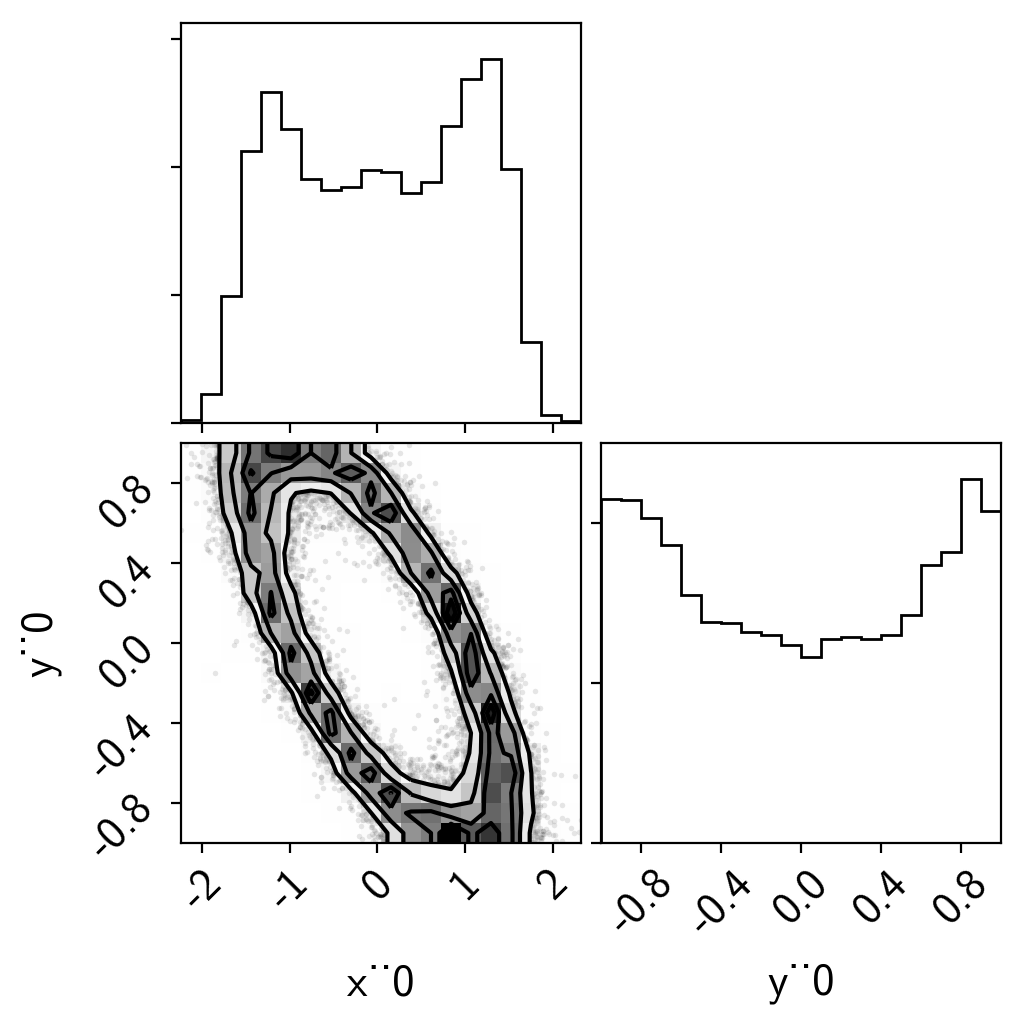

In [8]:
import corner
samples = pm.trace_to_dataframe(trace)
corner.corner(samples);